# Train using LDA algorithm

In [12]:
import gensim
import nltk
nltk.download('wordnet')

import pandas as pd
from sklearn.manifold import TSNE
import time

from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading BokehJS ...

# Preprocess Documents

In [3]:
def read_json_docs(filename):
    dataset_df = pd.read_csv(filename, error_bad_lines=False)
    
    dataset = dataset_df['text']
    
    return dataset


def preprocess(raw_docs):
    """
    Preprocess documents including normalization, lemmatization, tokenization, removing stopwords.

    Args:
        raw_docs (pandas.Series)
    
    Returns:
        docs (list(list(str)))
    """
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    docs = []
    
    for d in raw_docs:
        tokens = gensim.utils.simple_preprocess(d)
        stopwords_custom = ['https', 'rt', 'amp'] 
        doc = []
        
        for t in tokens:
            if t not in gensim.parsing.preprocessing.STOPWORDS:
                if t not in stopwords_custom:
                    t = lemmatizer.lemmatize(t, pos='v') # convert past tense to present tense.
                    doc.append(t)
                    
        docs.append(doc)
        
    return docs
        
       
def create_dictionary(docs):
    """
    Create dictionary
    
    Args:
        docs (list(list(str)))
        
    Returns:
        dictionary (gensim.corpora.Dictionary)
    """
    
    return gensim.corpora.Dictionary(docs)
    
    
def get_bow_corpus(docs, dictionary):
    """
    Convert texts to encoded bows using dictionary
    
    Args:
        docs (list(list(str))):
        dictionary (gensim.corpora.Dictionary)
        
    Returns:
        bows (list(list(tuple(token_id, token_count))))
    """
    bows = [dictionary.doc2bow(d) for d in docs]
    return bows


def get_tfidf_corpus(bows):
    tfidf_model = gensim.models.TfidfModel(bows)
    corpus_tfidf = tfidf_model[bows]
    
    return corpus_tfidf, tfidf_model

# Traning Program

In [4]:
filename_dataset = './twitter_trump_2019_05.csv'
no_below = 2
no_above = 1.0
num_topics = 3
passes = 20


# Read file
raw_docs = read_json_docs(filename_dataset)

# Preprocess documents including normalization, lemmatization, tokenization, removing stopwords.
docs = preprocess(raw_docs)

# Create dictionary
dictionary = create_dictionary(docs)
print('Size of unfiltered dictionary: {}'.format(len(dictionary)))

# Remove common/rare words
dictionary.filter_extremes(no_below=no_below, no_above=no_above)
print('Size of filtered dictionary: {}'.format(len(dictionary)))

# Transform docs to BOWs corpus
corpus_bows = get_bow_corpus(docs, dictionary)

# Transform BOWS to TF-IDF corpus
corpus_tfidf, tfidf_model = get_tfidf_corpus(corpus_bows)


Size of unfiltered dictionary: 2724
Size of filtered dictionary: 1162


In [32]:
# Train the corpus_bows
lda_model_bows = gensim.models.LdaModel(corpus_bows, num_topics=num_topics, id2word=dictionary,passes=passes)

# Train the corpus_bows
lda_model_tfidf = gensim.models.LdaModel(corpus_tfidf,
                                              num_topics=num_topics,
                                              id2word=dictionary,
                                              passes=passes)

# Save Dictionary and Models

In [5]:
filename_dictionary = './dictionary.dict'
filename_bow_model = './model_bow.lda'
filename_tfidf_model = './model_tfidf.lda'

In [37]:
# save dictionary
dictionary.save(filename_dictionary)

# save BOW model
lda_model_bows.save(filename_bow_model)
lda_model_tfidf.save(filename_tfidf_model)

# Display Key Factors of Each Topic

In [20]:
def get_keywords_df(model):
    init_values = [['']*num_topics]*10
    keywords_df = pd.DataFrame(init_values, columns=['topic{}'.format(i) for i in range(num_topics)])


    for i_topic, topic in model.show_topics(-1, formatted=False):
        for i_word, (word, weight) in enumerate(topic):
            keywords_df.iloc[i_word][i_topic] = word
            
    return keywords_df
    
    
def plot_word_cloud(keywords_df):
    num_topics = len(keywords_df.iloc[0])
    
    fig, axs = plt.subplots(num_topics)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    for i_topic in range(num_topics):
        text = ' '.join(w for w in keywords_df.iloc[:, i_topic])
        print('Topic {}: {}'.format(i_topic, text))
        wordCloud = WordCloud(background_color='white').generate(text)

        axs[i_topic].imshow(wordCloud)
        axs[i_topic].axis('off')
        axs[i_topic].set_title('Topic {}'.format(i_topic), size=20)
        

Topic 0: dbongino great today trump job joe china vote realdonaldtrump biden
Topic 1: president mueller democrats report collusion trump realdonaldtrump tomfitton know want
Topic 2: china great tariff dollars state president billion want japan years


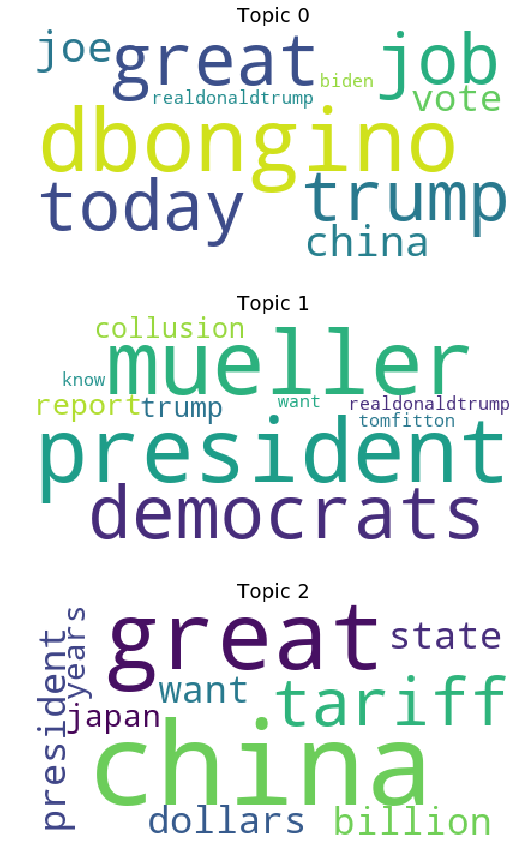

In [21]:
keywords_bow_df = get_keywords_df(lda_model_bow)
plot_word_cloud(keywords_bow_df)

Topic 0: america great realdonaldtrump thank work come today big foxnews presidential
Topic 1: job state trump realdonaldtrump great china win obama dbongino president
Topic 2: dbongino china mueller democrats go report vote collusion japan want


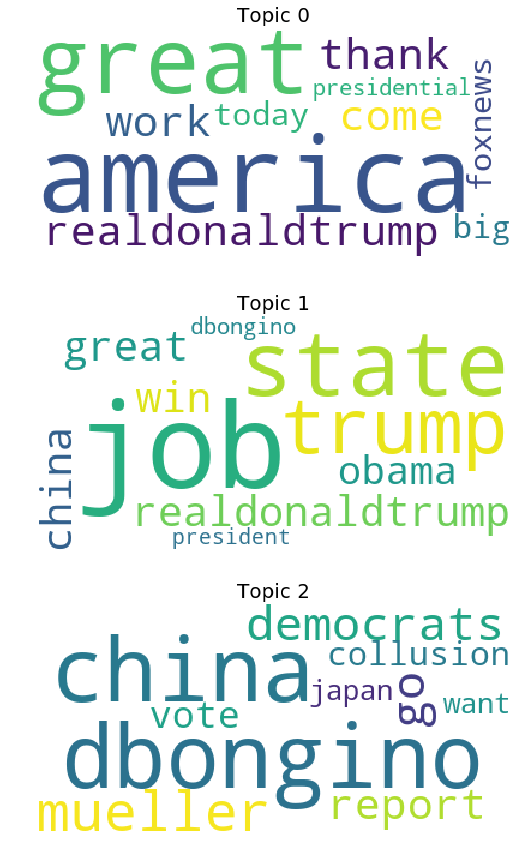

In [22]:
keywords_df = get_keywords_df(lda_model_tfidf)
plot_word_cloud(keywords_df)

# Restore Dictionary and Models

In [8]:
lda_model_bow = gensim.models.LdaModel.load(filename_bow_model)
lda_model_tfidf = gensim.models.LdaModel.load(filename_tfidf_model)

# Classify Documents

In [24]:
def argmax_prob(topic_probs):
    """
    Get the index with max probability
    
    Args:
        topic_probs (list of (topic_id, topic_probability)):
        
    Returns:
        index (int): index with maximum probability
    """
    max_value = -1
    index_max_prob = 0
    
    for index, value in topic_probs:
        if value > max_value:
            max_value = value
            index_max_prob = index
            
    return index_max_prob        
    
    
def get_topic_probs(corpus, model):
    """
    Get topics of corpus
    
    Args:
        corpus
        model
    """
    topic_probs = []
    
    for c in corpus:
        results = model[c]
        
        probs = []
        for index, p in results:
            probs.append(p)
            
        topic_probs.append(probs)
        
    return topic_probs

In [25]:
prob_bows = get_topic_probs(corpus_bows, lda_model_bow)
topic_bows = np.argmax(prob_bows, axis=1)

print(prob_bows[:5])
print(topic_bows[:5])

[[0.020071786, 0.13314654, 0.84678161], [0.066822775, 0.86596817, 0.067209058], [0.043979134, 0.9109475, 0.04507339], [0.95504236, 0.019284619, 0.025673063], [0.023807652, 0.21811159, 0.75808072]]
[2 1 1 0 2]


In [26]:
prob_tfidf = get_topic_probs(corpus_tfidf, lda_model_tfidf)
topic_tfidf = np.argmax(prob_tfidf, axis=1)

print(prob_tfidf[:5])
print(topic_bows[:5])

[[0.84335369, 0.071857482, 0.084788807], [0.11815603, 0.44043615, 0.4414078], [0.79112333, 0.10427633, 0.1046003], [0.084659703, 0.081904314, 0.83343601], [0.52161944, 0.080190696, 0.39818981]]
[2 1 1 0 2]


# Display Probabilistic Results Using t-SNE

In [27]:
SEED = 0
tsne = TSNE(perplexity=10, n_components=2, random_state=SEED)

X_tsne = tsne.fit_transform(prob_tfidf)

In [28]:
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'skyblue', 5:'salmon', 6:'orange', 7:'maroon', 8:'crimson', 9:'black', 10:'gray'}

labels = ['Topic {}'.format(i) for i in topic_tfidf]
topic_colors = [cluster_colors[i] for i in topic_tfidf]

settings = dict(x=X_tsne[:, 0],
               y = X_tsne[:, 1],
                label=labels,
                color=topic_colors,
               content=raw_docs[:])

source = ColumnDataSource(settings)

title = 'T-SNE visualization of Trump\'s twitts'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source, 
                 color='color', alpha=0.8, size=10)#'msize', )

hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content"}
plot_lda.legend.location = "top_left"

show(plot_lda)